# Support Vector Machine (SVM) Classification on PCA Chi dataset

Link to Excel file of extracted features: https://drive.google.com/drive/u/1/folders/1ZMbW7HxNkBUAlnT-_lXLD4J_r0A778SJ

In [1]:
# import required packages
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV


In [2]:
# read in features csv file
df = pd.read_csv('chi_pca_features.csv')
df

,PC1,PC2,PC3,PC4,label
0,4.127092,1.017250,1.710357,-1.310324,chi_pre
1,-1.047665,0.968566,1.815919,0.754062,chi_pre
2,0.202165,2.289469,3.323522,1.881058,chi_pre
3,1.298339,1.338633,1.269045,-1.095397,chi_pre
4,-1.148704,-0.171344,0.576492,-0.821199,chi_pre
...,...,...,...,...,...
187,-1.622496,1.410235,-2.179585,-0.396197,chi_med
188,-2.449131,-0.095308,-2.510813,0.199345,chi_med
189,-1.689727,0.454423,-2.617688,-0.181970,chi_med
190,-1.959745,1.467207,-2.073600,-0.028477,chi_med


In [3]:
# encode meditative/non-meditative labels
categories = {'chi_pre':0,'chi_med':1}
df['label'] = df['label'].replace(categories)
df

,PC1,PC2,PC3,PC4,label
0,4.127092,1.017250,1.710357,-1.310324,0
1,-1.047665,0.968566,1.815919,0.754062,0
2,0.202165,2.289469,3.323522,1.881058,0
3,1.298339,1.338633,1.269045,-1.095397,0
4,-1.148704,-0.171344,0.576492,-0.821199,0
...,...,...,...,...,...
187,-1.622496,1.410235,-2.179585,-0.396197,1
188,-2.449131,-0.095308,-2.510813,0.199345,1
189,-1.689727,0.454423,-2.617688,-0.181970,1
190,-1.959745,1.467207,-2.073600,-0.028477,1


In [4]:
# split dependent and independent variables
# target variable
Y = df['label'].values
# features
X = df.drop(labels = ['label'], axis = 1)
features_list = list(X.columns)

# Standardizing the features
X = StandardScaler().fit_transform(X)

In [5]:
# split training and testing dataset: 70% training, 30% testing
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size = 0.3,random_state = 42)

## Linear SVM

In [6]:
# create lists of possible parameters for linear SVM
# to be used in grid search to find the best possible parameters later

lin_clf_loss = ['hinge', 'squared_hinge']
lin_clf_dual = [True,False]
lin_clf_tol = [0.001,0.0001,0.00001]

# Create the grid
lin_grid = {'loss': lin_clf_loss,
               'dual': lin_clf_dual,
               'tol': lin_clf_tol}

lin_grid

{'loss': ['hinge', 'squared_hinge'],
 'dual': [True, False],
 'tol': [0.001, 0.0001, 1e-05]}

In [7]:
# run parameters through model and find best set of parameters
# this step splits the training data into mini train/test datasets to find the best hyperparameters for the model

import time
print(time.ctime(time.time()))

# Create the model to be tuned
lin_base = svm.LinearSVC()

# Create the random search to find best hyperparameters
lin_random = RandomizedSearchCV(estimator = lin_base, 
                                param_distributions = lin_grid, 
                                n_iter = 20,
                                cv = 10, 
                                verbose = 2, 
                                random_state = 42, 
                                n_jobs = -1)

# Fit the random search model on training data
lin_random.fit(X_train, y_train)

print(time.ctime(time.time()))

Thu Apr 15 00:36:12 2021
Fitting 10 folds for each of 12 candidates, totalling 120 fits


/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:278: UserWarning: The total space of parameters 12 is smaller than n_iter=20. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Thu Apr 15 00:36:14 2021


[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.8s finished


In [8]:
# show best set of parameters
lin_random.best_params_

{'tol': 0.001, 'loss': 'hinge', 'dual': True}

In [9]:
# Create the linear SVM model
lin_model = svm.LinearSVC(tol = 0.001,
                      loss = 'hinge',
                      dual = True,
                      random_state = 42)

In [10]:
# fit model
lin_model.fit(X_train,y_train)

LinearSVC(loss='hinge', random_state=42, tol=0.001)

In [11]:
# predict y values from testing data
y_pred = lin_model.predict(X_test)

In [12]:
# display results in confusion matrix
cm = confusion_matrix(y_test,y_pred)
cm

results = pd.crosstab(y_test, y_pred, colnames=['Predicted'])
results = results.rename(columns={0: 'Non-Meditative', 1: 'Meditative'})
results.index = ['Non-Meditative', 'Meditative']
index = results.index
index.name = "Actual"
results

Predicted,Non-Meditative,Meditative
Actual,,
Non-Meditative,20,8
Meditative,4,26


In [13]:
target_names = ['Non-Meditative', 'Meditative']
print(classification_report(y_test, y_pred, target_names=target_names))

                precision    recall  f1-score   support

Non-Meditative       0.83      0.71      0.77        28
    Meditative       0.76      0.87      0.81        30

      accuracy                           0.79        58
     macro avg       0.80      0.79      0.79        58
  weighted avg       0.80      0.79      0.79        58



In [14]:
# store metrics for comparision amongst SVM kernels later
svm_rec = []
svm_acc = []
svm_pre = []
svm_mcc = []

# obtain metrics for model
recall = metrics.recall_score(y_test,y_pred)
accuracy = metrics.accuracy_score(y_test,y_pred)
precision = metrics.precision_score(y_test,y_pred)
mcc = metrics.matthews_corrcoef(y_test,y_pred)

svm_rec.append(recall)
svm_acc.append(accuracy)
svm_pre.append(precision)
svm_mcc.append(mcc)

# display metrics
print('Linear SVM\n')
print('Sensitivity = %.3f' % recall)
print('Accuracy = %.3f' % accuracy)
print('Precision = %.3f' % precision)
print('Matthew Correlation Coefficient = %.3f' % mcc)


Linear SVM

Sensitivity = 0.867
Accuracy = 0.793
Precision = 0.765
Matthew Correlation Coefficient = 0.589


In [15]:
# show most important features when determining classification category
feature_imp = pd.Series(lin_model.coef_[0], index = features_list).sort_values(ascending = False)
feature_imp

PC3   -0.451225
PC4   -0.570157
PC2   -0.847228
PC1   -0.861374
dtype: float64

## Radial Basis Function SVM

In [16]:
# create lists of possible parameters for rbf SVM
# to be used in grid search to find the best possible parameters later

rbf_gamma = [0.1, 1,'scale','auto']
rbf_tol = [0.001,0.0001,0.00001]

# Create the grid
rbf_grid = {'gamma': rbf_gamma,
               'tol': rbf_tol}

rbf_grid


{'gamma': [0.1, 1, 'scale', 'auto'], 'tol': [0.001, 0.0001, 1e-05]}

In [17]:
# run parameters and find set with best score
# this step splits the training data into mini train/test datasets to find the best hyperparameters for the model

print(time.ctime(time.time()))

# Create the model to be tuned
rbf_base = svm.SVC(kernel = 'rbf')

# Create the random search to find best hyperparameters
rbf_random = RandomizedSearchCV(estimator = rbf_base, 
                                param_distributions = rbf_grid, 
                                n_iter = 10,
                                cv = 10, 
                                verbose = 2, 
                                random_state = 42, 
                                n_jobs = -1)

# Fit the random search model on training data
rbf_random.fit(X_train, y_train)

print(time.ctime(time.time()))

Thu Apr 15 00:36:33 2021
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Thu Apr 15 00:36:33 2021


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished


In [18]:
# display best rbf svm parameters
rbf_random.best_params_

{'tol': 1e-05, 'gamma': 1}

In [19]:
# Create the rbf SVM model
rbf_model = svm.SVC(kernel = 'rbf',
                    tol = 1e-05,
                      gamma = 1,
                      random_state = 42)

# fit model
rbf_model.fit(X_train,y_train)

# predict testing data
y_pred = rbf_model.predict(X_test)

# display confusion matrix
results = pd.crosstab(y_test, y_pred, colnames=['Predicted'])
results = results.rename(columns={0: 'Non-Meditative', 1: 'Meditative'})
results.index = ['Non-Meditative', 'Meditative']
index = results.index
index.name = "Actual"
results

Predicted,Non-Meditative,Meditative
Actual,,
Non-Meditative,22,6
Meditative,4,26


In [20]:
# obtain metrics of rbf model
recall = metrics.recall_score(y_test,y_pred)
accuracy = metrics.accuracy_score(y_test,y_pred)
precision = metrics.precision_score(y_test,y_pred)
mcc = metrics.matthews_corrcoef(y_test,y_pred)

svm_rec.append(recall)
svm_acc.append(accuracy)
svm_pre.append(precision)
svm_mcc.append(mcc)

print('Radial Basic Function SVM\n')
print('Sensitivity = %.3f' % recall)
print('Accuracy = %.3f' % accuracy)
print('Precision = %.3f' % precision)
print('Matthew Correlation Coefficient = %.3f' % mcc)

Radial Basic Function SVM

Sensitivity = 0.867
Accuracy = 0.828
Precision = 0.812
Matthew Correlation Coefficient = 0.656


## Polynomial SVM

In [21]:
# create lists of possible parameters for polynomial SVM
# to be used in grid search to find the best possible parameters later

poly_degree = [2,3,4,5,6,7]
poly_gamma = [0.1, 1,'scale','auto']
poly_tol = [0.001,0.0001,0.00001]

# Create the grid
poly_grid = {'gamma': poly_gamma,
            'degree': poly_degree,
               'tol': poly_tol}

poly_grid


{'gamma': [0.1, 1, 'scale', 'auto'],
 'degree': [2, 3, 4, 5, 6, 7],
 'tol': [0.001, 0.0001, 1e-05]}

In [22]:
# this step splits the training data into mini train/test datasets to find the best hyperparameters for the model

print(time.ctime(time.time()))

# Create the model to be tuned
poly_base = svm.SVC(kernel = 'poly')

# Create the random search to find best hyperparameters
poly_random = RandomizedSearchCV(estimator = poly_base, 
                                param_distributions = poly_grid, 
                                n_iter = 100,
                                cv = 10, 
                                verbose = 2, 
                                random_state = 42, 
                                n_jobs = -1)

# Fit the random search model on training data
poly_random.fit(X_train, y_train)

print(time.ctime(time.time()))

Thu Apr 15 00:36:41 2021
Fitting 10 folds for each of 72 candidates, totalling 720 fits


/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:278: UserWarning: The total space of parameters 72 is smaller than n_iter=100. Running 72 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.3s


Thu Apr 15 00:36:42 2021


[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:    1.1s finished


In [23]:
# display best polynomial svm parameters
poly_random.best_params_

{'tol': 0.001, 'gamma': 'scale', 'degree': 3}

In [24]:
# Create the poly SVM model
poly_model = svm.SVC(kernel = 'poly',
                    tol = 0.001,
                    gamma = 'scale',
                    degree = 3,
                    random_state = 42)

# fit model
poly_model.fit(X_train,y_train)

# predict test data
y_pred = poly_model.predict(X_test)

# confusion matrix
results = pd.crosstab(y_test, y_pred, colnames=['Predicted'])
results = results.rename(columns={0: 'Non-Meditative', 1: 'Meditative'})
results.index = ['Non-Meditative', 'Meditative']
index = results.index
index.name = "Actual"
results

Predicted,Non-Meditative,Meditative
Actual,,
Non-Meditative,26,2
Meditative,5,25


In [25]:
# evaluation metrics of poly svm model
recall = metrics.recall_score(y_test,y_pred)
accuracy = metrics.accuracy_score(y_test,y_pred)
precision = metrics.precision_score(y_test,y_pred)
mcc = metrics.matthews_corrcoef(y_test,y_pred)

svm_rec.append(recall)
svm_acc.append(accuracy)
svm_pre.append(precision)
svm_mcc.append(mcc)

print('Polynomial SVM\n')
print('Sensitivity = %.3f' % recall)
print('Accuracy = %.3f' % accuracy)
print('Precision = %.3f' % precision)
print('Matthew Correlation Coefficient = %.3f' % mcc)

Polynomial SVM

Sensitivity = 0.833
Accuracy = 0.879
Precision = 0.926
Matthew Correlation Coefficient = 0.763


### Comparison Between SVM models

In [26]:
df = pd.DataFrame()

df['svm kernel'] = ['linear','rbf','poly']
df['sensitivity'] = svm_rec
df['accuracy'] = svm_acc
df['precision'] = svm_pre
df['mcc'] = svm_mcc

df

,svm kernel,sensitivity,accuracy,precision,mcc
0,linear,0.866667,0.793103,0.764706,0.589434
1,rbf,0.866667,0.827586,0.812500,0.655510
2,poly,0.833333,0.879310,0.925926,0.763269


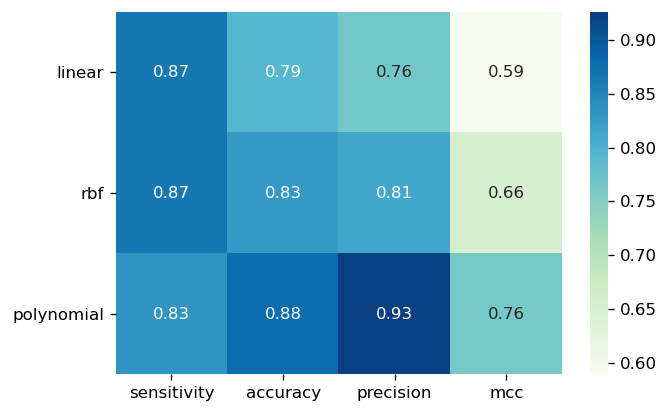

In [27]:
y_axis_labels = ['linear','rbf','polynomial']

plt.figure(dpi = 120)
ax = sns.heatmap(df.iloc[:, 1:],
                 cmap = 'GnBu',
                 annot = True,
                 yticklabels = y_axis_labels,
                )

plt.yticks(rotation=0) 
plt.show()

Polynomial SVM showed best performance overall